# Step 5 - Plotting bicycle network analysis results
## Project: Growing Urban Bicycle Networks

This notebook takes the results from 03_poi_based_generation and 04_analyze_results, and plots them.
Results on car-constricted networks, if available from X_carconstricted_metrics, can be plotted by 
setting `plotconstricted = True`.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-07-08  
Last modified: 2024-09-24

## Preliminaries

### Parameters

In [1]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"
plotconstricted = False # If True, will add plots about constricted street network metrics.

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py
if not debug: # Only do this if sure the code is bug-free!
    warnings.filterwarnings('ignore')

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.

Setup finished.

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 4c5cd0bc50c1c154868417f99214b4182b4fb9b5

sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
shapely   : 2.0.6
networkx  : 3.3
rasterio  : 1.3.11
momepy    : 0.8.1
numpy     : 1.26.4
osgeo     : 3.9.3
owslib    : 0.32.0
haversine : 2.8.1
osmnx     : 1.9.4
fiona     : 1.10.1
pandas    : 2.2.3
geopandas : 0.14.4
geojson   : 3.1.0
pyproj    : 3.7.0
json      : 2.0.9
tqdm      : 4.66.5
IPython   : 8.29.0
csv       : 1.0
watermark : 2.5.0
igraph    : 0.11.6
matplotlib: 3.8.4



### Functions

In [3]:
%run -i functions.py

Loaded functions.



## Plot

### Analysis plots

LTNs_tessellation betweenness


Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Plotting analysis results...


ValueError: x and y must have same first dimension, but have shapes (40,) and (8,)

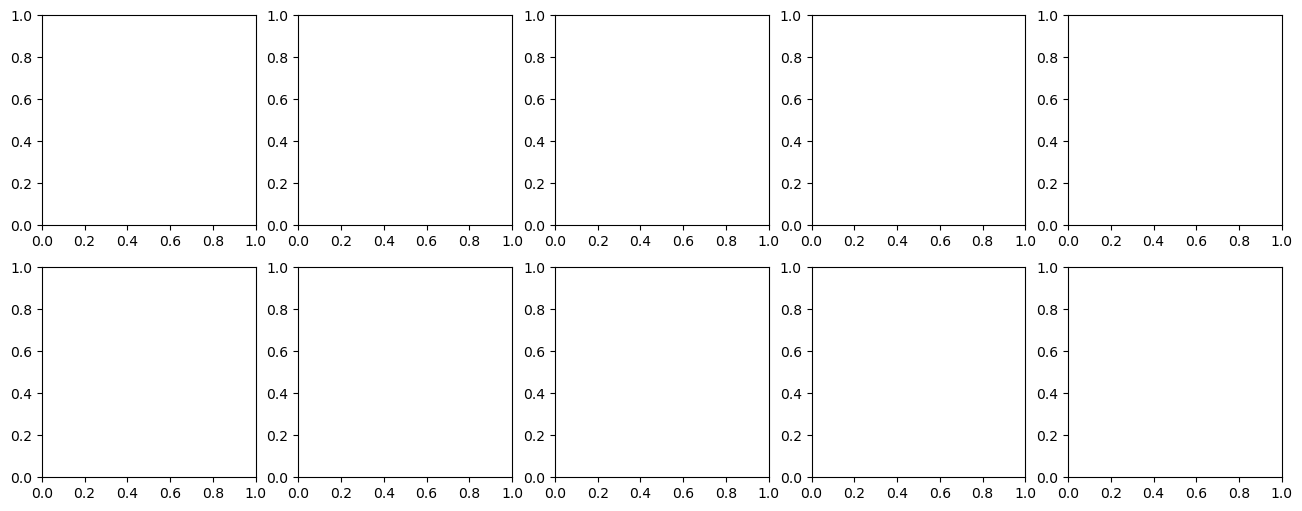

In [ ]:
# Either: Run all parameter sets
# poi_source_list = ["grid", "railwaystation"]
# prune_measure_list = ["betweenness", "closeness", "random"]
# parsets_used = list(itertools.product(poi_source_list, prune_measure_list))

# Or: Run one parameter set
parsets_used = [(poi_source, prune_measure)]

for poi_source_this, prune_measure_this in parsets_used:
    print(poi_source_this, prune_measure_this)

    for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    
        # PLOT Analysis
        filename = placeid + '_poi_' + poi_source_this + "_" + prune_measure_this + ("_weighted" if weighting else "") + ".csv"
        analysis_result = np.genfromtxt(PATH["results"] + placeid + "/" + filename, delimiter=',', names=True)
        if len(analysis_result) == 0:  # No plot if no results (for example no railwaystations)
            print(placeid + ": No analysis results available")
            continue

        print(placeid + ": Plotting analysis results...")

        # Load existing networks
        # G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
        # G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
        # G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
        # G_biketrack_onstreet = intersect_igraphs(G_biketrack, G_carall)
        # G_bikeable_onstreet = intersect_igraphs(G_bikeable, G_carall)

        filename = placeid + '_poi_' + poi_source_this + ("_weighted_mst" if weighting else "_mst") + ".csv"
        analysis_mst_result = np.genfromtxt(PATH["results"] + placeid + "/" + filename, delimiter=',', names=True)

        filename = placeid + "_existing" + ("_weighted" if weighting else "") + ".csv"
        analysis_existing = np.genfromtxt(PATH["results"] + placeid + "/" + filename, delimiter=',', names=True)

        prune_quantiles_constricted = prune_quantiles
        if plotconstricted:
            f = PATH["results_constricted"] + "results_" + poi_source_this + "_" + prune_measure_this + "/metrics_" + poi_source_this + "_" + prune_measure_this + "/" + placeid + "_carconstrictedbike_poi_" + poi_source_this + "_" + prune_measure_this + ("_weighted" if weighting else "") + ".csv"
            if os.path.isfile(f):
                analysis_result_constricted = np.loadtxt(f, delimiter=',', usecols=(2, 3, 4, 5, 6, 7, 8, 9, 10), skiprows=1)
                if np.shape(analysis_result_constricted)[0] == 3:  # for large cities we only calculated 3 values
                    prune_quantiles_constricted = [prune_quantiles[19], prune_quantiles[-1]]

        nc = 5
        fig, axes = plt.subplots(nrows=2, ncols=nc, figsize=(16, 6))
        # Bike network
        keys_metrics = {"length": "Length [km]", "coverage": "Coverage [km$^2$]", "overlap_biketrack": "Overlap Protected", "directness_all_linkwise": "Directness", "efficiency_global": "Global Efficiency",
                        "length_lcc": "Length of LCC [km]", "poi_coverage": "POIs covered", "overlap_bikeable": "Overlap Bikeable", "components": "Components", "efficiency_local": "Local Efficiency"}

        for i, ax in enumerate(axes[0]):
            key = list(keys_metrics.keys())[i]
            if key in ["overlap_biketrack", "overlap_bikeable"]:
                ax.plot(prune_quantiles, analysis_result[key] / analysis_result["length"], **plotparam_analysis["bikegrown"])
            elif key in ["efficiency_global", "efficiency_local"]:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown_abstract"])
                xmin, xmax = ax.get_xlim()
                tmp, = ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"])  # MST is equivalent for abstract and routed
                tmp.set_label('_hidden')
                tmp, = ax.plot(prune_quantiles, analysis_result[key + "_routed"], **plotparam_analysis["bikegrown"])
                tmp.set_label('_hidden')
            elif key in ["length", "length_lcc"]:  # Convert m->km
                ax.plot(prune_quantiles, analysis_result[key] / 1000, **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key] / 1000, analysis_mst_result[key] / 1000], **plotparam_analysis["mst"])
            else:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"])

            try:
                if key in ["length", "length_lcc"]:  # Convert m->km
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]] / 1000, analysis_existing[key][analysis_existing_rowkeys["biketrack"]] / 1000], **plotparam_analysis["biketrack"])
                else:
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]], analysis_existing[key][analysis_existing_rowkeys["biketrack"]]], **plotparam_analysis["biketrack"])
                if key in ["efficiency_global", "efficiency_local"]:
                    tmp.set_label('_hidden')

                if key in ["length", "length_lcc"]:  # Convert m->km
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]] / 1000, analysis_existing[key][analysis_existing_rowkeys["bikeable"]] / 1000], **plotparam_analysis["bikeable"])
                else:
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]], analysis_existing[key][analysis_existing_rowkeys["bikeable"]]], **plotparam_analysis["bikeable"])
                if key in ["efficiency_global", "efficiency_local"]:
                    tmp.set_label('_hidden')
            except:
                pass

            if key == "efficiency_global" and plotconstricted:
                ax.plot([0] + prune_quantiles_constricted, analysis_result_constricted[:, 0], **plotparam_analysis["constricted"])

            if i == 0:
                ymax0 = ax.get_ylim()[1]
                ax.set_ylim(0, ymax0)
                title_text = placeinfo['name'] + " (" + poi_source_this + " | " + prune_measure_this
                if weighting:
                    title_text += " | on weighted network"
                title_text += ")"

                # Add the title to the plot
                ax.text(-0.15, ymax0 * 1.25, title_text, fontsize=16, horizontalalignment='left')
                ax.legend(loc='upper left')
            if i == 4:
                ax.legend(loc='best')

            if key == "directness_all_linkwise" and plotconstricted:
                ax.plot([0] + prune_quantiles_constricted, analysis_result_constricted[:, -1], **plotparam_analysis["constricted"])

            set_analysissubplot(key)
            ax.set_title(list(keys_metrics.values())[i])
            ax.set_xlabel('')
            ax.set_xticklabels([])

        for i, ax in enumerate(axes[1]):
            key = list(keys_metrics.keys())[i + nc]
            if key in ["overlap_biketrack", "overlap_bikeable"]:
                ax.plot(prune_quantiles, analysis_result[key] / analysis_result["length"], **plotparam_analysis["bikegrown"])
            elif key in ["efficiency_global", "efficiency_local"]:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown_abstract"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"])  # MST is equivalent for abstract and routed
                ax.plot(prune_quantiles, analysis_result[key + "_routed"], **plotparam_analysis["bikegrown"])
            elif key in ["length", "length_lcc"]:  # Convert m->km
                ax.plot(prune_quantiles, analysis_result[key] / 1000, **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key] / 1000, analysis_mst_result[key] / 1000], **plotparam_analysis["mst"])
            else:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown"])

            try:
                if key in ["length", "length_lcc"]:  # Convert m->km
                    ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]] / 1000, analysis_existing[key][analysis_existing_rowkeys["biketrack"]] / 1000], **plotparam_analysis["biketrack"])
                    ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]] / 1000, analysis_existing[key][analysis_existing_rowkeys["bikeable"]] / 1000], **plotparam_analysis["bikeable"])
                else:
                    ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]], analysis_existing[key][analysis_existing_rowkeys["biketrack"]]], **plotparam_analysis["biketrack"])
                    ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]], analysis_existing[key][analysis_existing_rowkeys["bikeable"]]], **plotparam_analysis["bikeable"])
            except:
                pass

            if key == "efficiency_local" and plotconstricted:
                ax.plot([0] + prune_quantiles_constricted, analysis_result_constricted[:, 1], **plotparam_analysis["constricted"])

            if i == 0:
                ax.set_ylim(0, ymax0)
            set_analysissubplot(key)
            ax.set_title(list(keys_metrics.values())[i + nc])
            ax.set_xlabel(prune_measure_this + ' quantile')
            if key in ["poi_coverage"]:
                # https://stackoverflow.com/questions/30914462/matplotlib-how-to-force-integer-tick-labels
                ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        plt.subplots_adjust(top=0.87, bottom=0.09, left=0.05, right=0.97, wspace=0.25, hspace=0.25)
        if plotconstricted:
            output_filename = (PATH["plots"] + placeid + "/" + placeid + '_analysis_poi_' + poi_source_this + "_" + prune_measure_this + 
                            ('_weighted.png' if weighting else '_noconstr.png'))
        else:
            output_filename = (PATH["plots"] + placeid + "/" + placeid + '_analysis_poi_' + poi_source_this + "_" + prune_measure_this + 
                            ('_noconstr_weighted.png' if weighting else '_noconstr.png'))

        print(f"Saving plot to: {output_filename}")
        fig.savefig(output_filename, facecolor="white", edgecolor='none')
        plt.close()


### Constricted analysis plots

In [7]:
if plotconstricted:
    for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
        prune_measure_this = "betweenness"
        for poi_source_this in ["railwaystation", "grid"]:
            
            # Adjust file paths to handle weighting
            filename_suffix = constricted_parameternamemap[prune_measure_this] + constricted_parameternamemap[poi_source_this]
            if weighting and "weighted" not in filename_suffix:
                filename_suffix += "_weighted"

            f = PATH["results_constricted"] + poi_source_this + "/" + placeid + filename_suffix + ".csv"
            
            if os.path.isfile(f):
                analysis_result_constricted = np.loadtxt(f, delimiter=',', usecols=(2, 3, 4, 5, 6, 7, 8, 9, 10), skiprows=1)
    
                fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 3))
    
                for i, ax in enumerate(axes):
                    ax.set_title(constricted_plotinfo["title"][i])
                    ax.set_xlabel(prune_measure_this + ' quantile')
                    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                    ax.set_xlim(-0.05, 1.05)
                    ax.spines['right'].set_visible(False)
                    ax.spines['top'].set_visible(False)
    
                    # Efficiency global
                    if i == 0:
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 0], **plotparam_analysis["constricted"])
                        ymin, ymax = ax.get_ylim()
                        ax.text(-0.25, ymin + (ymax - ymin) * 1.2, placeinfo['name'] + " streets (" + poi_source_this + ", " + prune_measure_this + " growth)", fontsize=16, horizontalalignment='left')
    
                    # Efficiency local
                    elif i == 1:
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 1], **plotparam_analysis["constricted"])
    
                    # Directness
                    elif i == 2:
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, -1], **plotparam_analysis["constricted"])
    
                    # Clustering
                    elif i == 3:
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 2], **plotparam_analysis["constricted_10"])
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 3], **plotparam_analysis["constricted_5"])
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 4], **plotparam_analysis["constricted_3"])
                        ax.legend(loc='best')
    
                    # Anisotropy
                    elif i == 4:
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 5], **plotparam_analysis["constricted_10"])
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 6], **plotparam_analysis["constricted_5"])
                        ax.plot([0] + prune_quantiles, analysis_result_constricted[:, 7], **plotparam_analysis["constricted_3"])
                        
                plt.subplots_adjust(top=0.79, bottom=0.16, left=0.05, right=0.97, wspace=0.25)
                
                # Save figure with correct weighted filename if applicable
                output_filename = placeid + '_analysis_poi_' + poi_source_this + "_" + prune_measure_this + '_constricted.png'
                fig.savefig(PATH["plots"] + placeid + "/" + output_filename, facecolor="white", edgecolor='none')
            else:
                print(placeid + " / " + poi_source_this + ": No results data for constricted analysis to plot")


### Network plots

#### Existing networks

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Plotting networks...


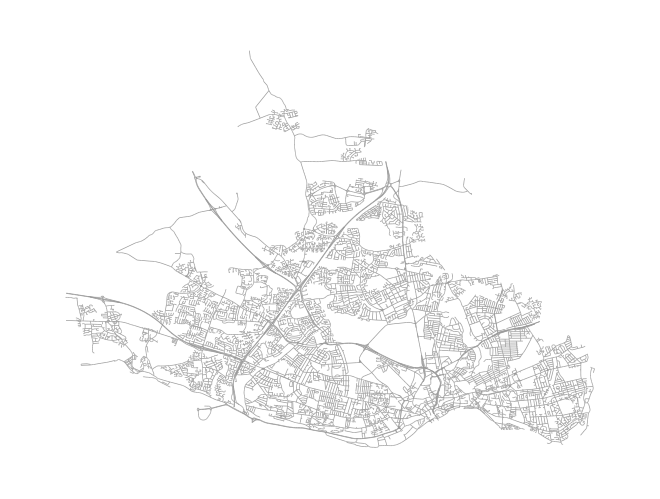

In [6]:
 for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Plotting networks...")
    
    if prune_measure == "betweenness":
        weight_abstract = True
    else:
        weight_abstract = 6
    
    # EXISTING INFRASTRUCTURE
    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
    G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    map_center = nxdraw(G_carall, "carall")
    
    # PLOT existing networks
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    try:
        G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
        fig = initplot()
        nxdraw(G_biketrack, "biketrack", map_center)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrack.pdf', bbox_inches="tight")
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrack.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()
        
        fig = initplot()
        nxdraw(G_carall, "carall", map_center)
        nxdraw(G_biketrack, "biketrack", map_center, list(set([v["id"] for v in G_biketrack.vs]).intersection(set([v["id"] for v in G_carall.vs]))))
        nxdraw(G_biketrack, "biketrack_offstreet", map_center, list(set([v["id"] for v in G_biketrack.vs]).difference(set([v["id"] for v in G_carall.vs]))))
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrackcarall.pdf', bbox_inches="tight")
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrackcarall.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()
    except:
        print(placeinfo["name"] + ": No bike tracks found")
    
    try:
        G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
        fig = initplot()
        nxdraw(G_bikeable, "bikeable", map_center)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_bikeable.pdf', bbox_inches="tight")
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_bikeable.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()
    except:
        print(placeinfo["name"] + ": No bikeable infrastructure found")
    
    
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    nodesize_poi = nodesize_from_pois(nnids)
    
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()

#### Grown networks

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Plotting networks...


KeyError: 'MST_abstract'

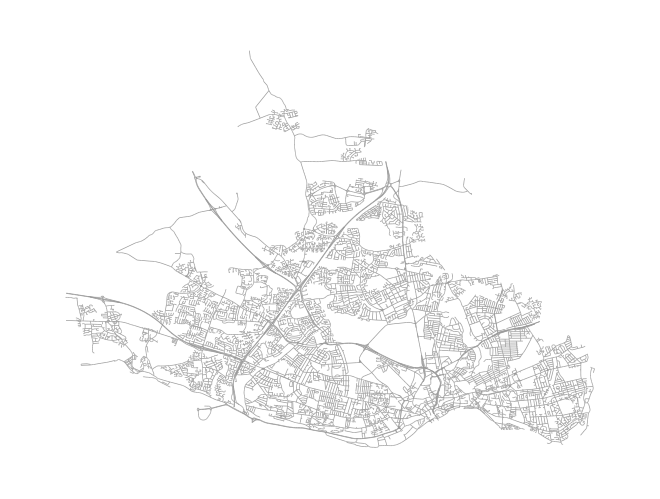

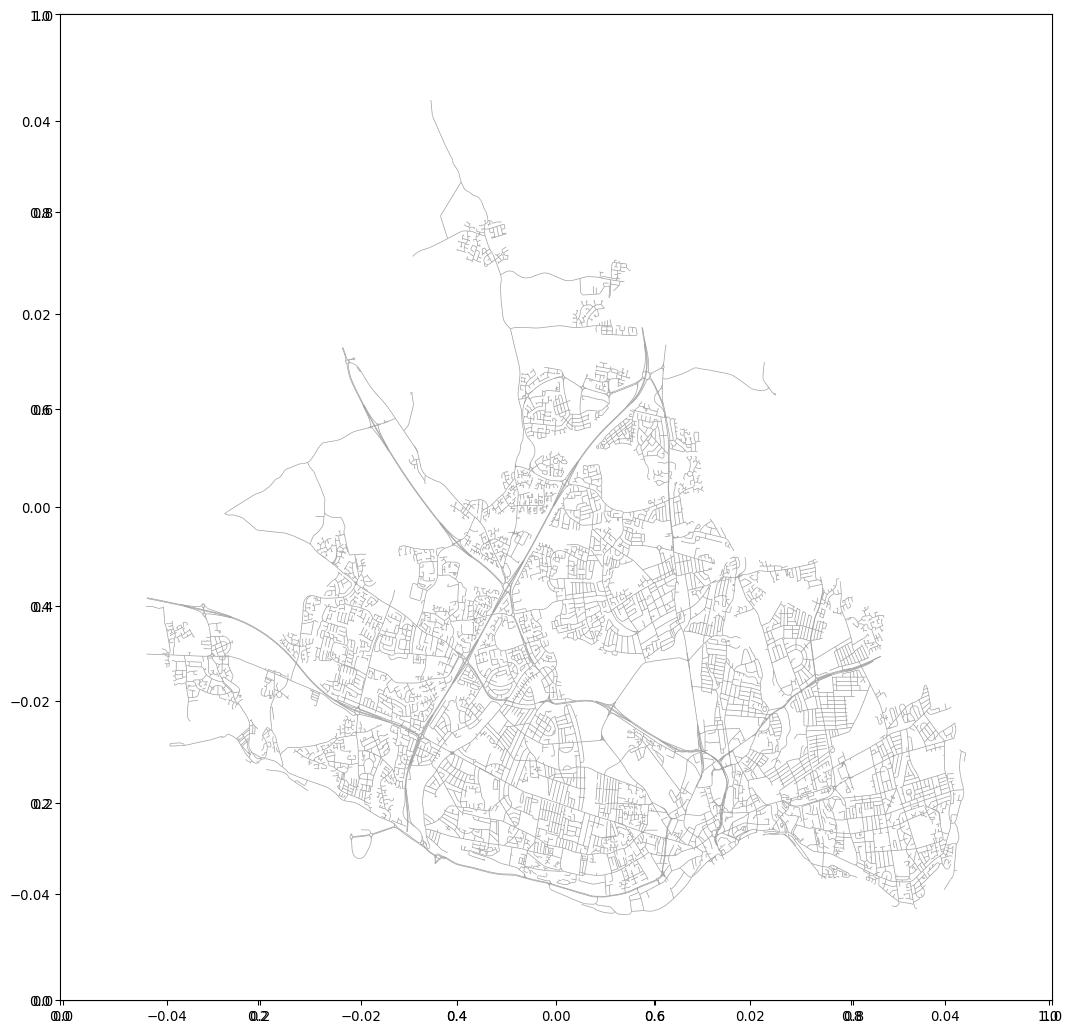

In [8]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Plotting networks...")

    if prune_measure == "betweenness":
        weight_abstract = True
    else:
        weight_abstract = 6

    # Adjust suffix for weighting if applicable
    weighting_suffix = "_weighted" if weighting else ""

    # EXISTING INFRASTRUCTURE
    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
    map_center = nxdraw(G_carall, "carall")


    ################################################### test to see which nodes we need to input for better plotting of hoods + tess ##############
    if poi_source == "neighbourhoods":
        with open(PATH["data"] + placeid + "/" + placeid + '_poi_tess_hoods_nnidscarall.csv') as f:
            nnids = [int(line.rstrip()) for line in f]
    else:
        # Load POIs
        with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
            nnids = [int(line.rstrip()) for line in f]
    ################################################### test to see which nodes we need to input for better plotting of hoods + tess ##############
    nodesize_poi = nodesize_from_pois(nnids)

    

    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source  + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source  + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()

    # GENERATED, POI BASED
    # Load results
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + weighting_suffix + ".pickle"
    with open(PATH["results"] + placeid + "/" + filename, 'rb') as f:
        res = pickle.load(f)
    if debug:
        pp.pprint(res)

    # PLOT abstract MST
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(res["MST_abstract"], "abstract", map_center, weighted=6)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in res["MST"].vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstract_poi_' + poi_source + weighting_suffix + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstract_poi_' + poi_source + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()

    # PLOT MST all together
    fig = initplot()
    nxdraw(G_carall, "carall")
    nxdraw(res["MST"], "bikegrown", map_center, nodesize=nodesize_grown)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in res["MST"].vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTall_poi_' + poi_source + weighting_suffix + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTall_poi_' + poi_source + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()

    # PLOT MST all together with abstract
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(res["MST"], "bikegrown", map_center, nodesize=0)
    nxdraw(res["MST_abstract"], "abstract", map_center, weighted=6)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in res["MST"].vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstractall_poi_' + poi_source + weighting_suffix + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstractall_poi_' + poi_source + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()

    # PLOT abstract greedy triangulation (this can take some minutes)
    for GT_abstract, prune_quantile in tqdm(zip(res["GT_abstracts"], res["prune_quantiles"]), "Abstract triangulation", total=len(res["prune_quantiles"])):
        fig = initplot()
        nxdraw(G_carall, "carall")
        try:
            GT_abstract.es["weight"] = GT_abstract.es["width"]
        except:
            pass
        nxdraw(GT_abstract, "abstract", map_center, drawfunc="nx.draw_networkx_edges", nodesize=0, weighted=weight_abstract, maxwidthsquared=nodesize_poi)
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT_abstract.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTabstract_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()

    # PLOT all together (this can take some minutes)
    for GT, prune_quantile in tqdm(zip(res["GTs"], res["prune_quantiles"]), "Routed triangulation", total=len(res["prune_quantiles"])):
        fig = initplot()
        nxdraw(G_carall, "carall")
        nxdraw(GT, "bikegrown", map_center, nodesize=nodesize_grown)
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTall_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()


#### Networks with overlap with existing bicycle infra

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Plotting networks...


Overlaps with biketracks:   0%|          | 0/114 [00:00<?, ?it/s]

Newcastle upon Tyne: No bike tracks found. Error: 'Attribute does not exist'


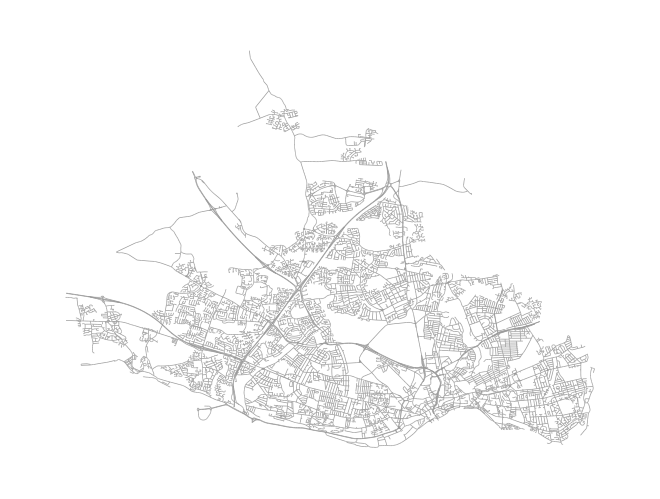

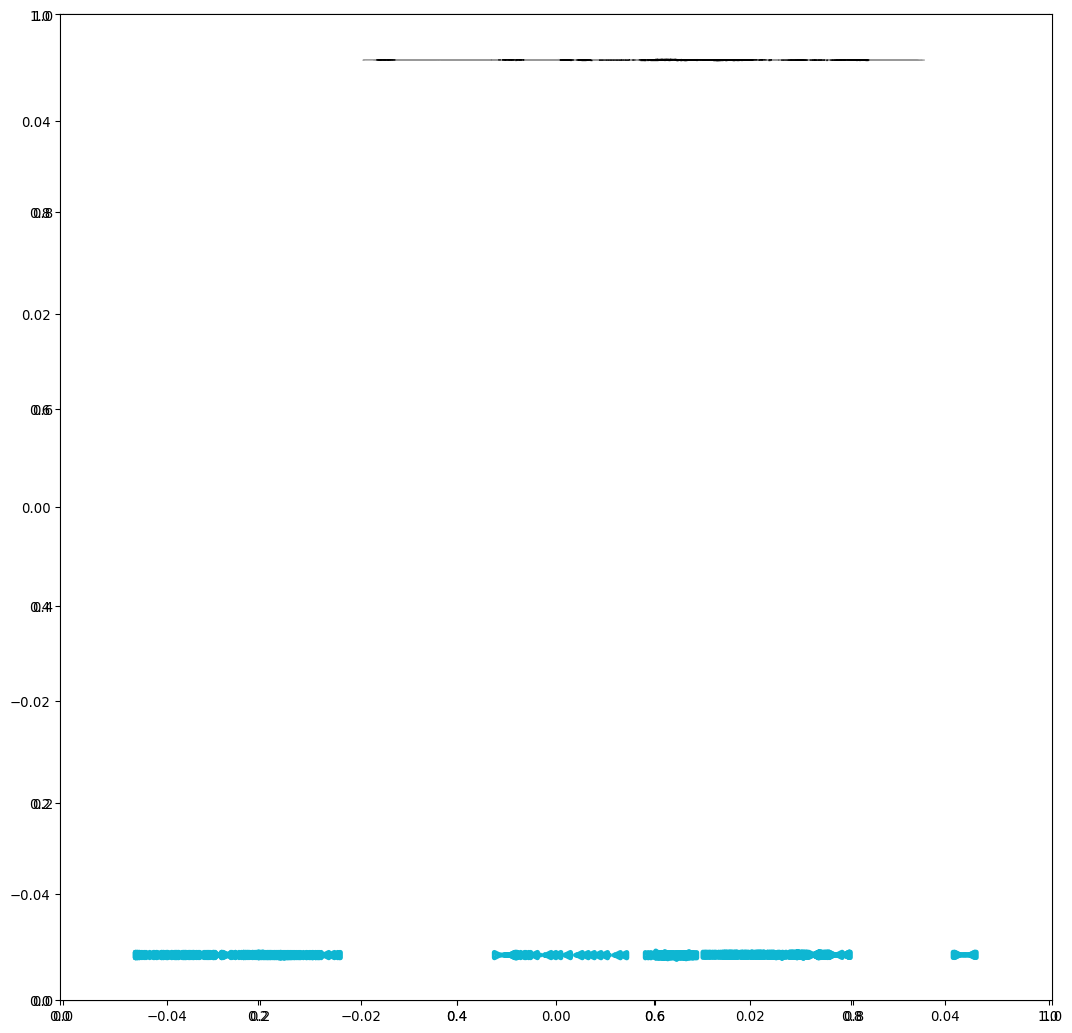

: 

In [ ]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Plotting networks...")
    
    # Adjust suffix for weighting if applicable
    weighting_suffix = "_weighted" if weighting else ""

    # Load results
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + weighting_suffix + ".pickle"
    with open(PATH["results"] + placeid + "/" + filename, 'rb') as f:
        res = pickle.load(f)
        
    ################################################### test to see which nodes we need to input for better plotting of hoods + tess ##############
    if poi_source == "neighbourhoods":
        with open(PATH["data"] + placeid + "/" + placeid + '_poi_tess_hoods_nnidscarall.csv') as f:
            nnids = [int(line.rstrip()) for line in f]
    else:
        # Load POIs
        with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
            nnids = [int(line.rstrip()) for line in f]
    ################################################### test to see which nodes we need to input for better plotting of hoods + tess ##############
        
    # EXISTING INFRASTRUCTURE
    try:
        # Load networks with weighting suffix where applicable
        G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
        G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
        G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
        G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
        
        map_center = nxdraw(G_carall, "carall")

        # PLOT all together with overlaps (this can take some minutes)
        for GT, prune_quantile in tqdm(zip(res["GTs"], res["prune_quantiles"]), "Overlaps with biketracks", total=len(res["prune_quantiles"])):
            fig = initplot()
            nxdraw(G_carall, "carall")
            nxdraw(G_biketrack, "biketrack", map_center, list(set([v["id"] for v in G_biketrack.vs]).intersection(set([v["id"] for v in G_carall.vs]))))
            nxdraw(GT, "bikegrown", map_center, nodesize=0)
            nxdraw(GT, "highlight_biketrack", map_center, list(set([v["id"] for v in G_biketrack.vs]).intersection(set([v["id"] for v in GT.vs]))))
            plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTalloverlapbiketrack_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
            plt.close()

        for GT, prune_quantile in tqdm(zip(res["GTs"], res["prune_quantiles"]), "Overlaps with bikeable", total=len(res["prune_quantiles"])):
            fig = initplot()
            nxdraw(G_carall, "carall")
            nxdraw(G_bikeable, "bikeable", map_center, list(set([v["id"] for v in G_bikeable.vs]).intersection(set([v["id"] for v in G_carall.vs]))))
            nxdraw(GT, "bikegrown", map_center, nodesize=0)
            nxdraw(GT, "highlight_bikeable", map_center, list(set([v["id"] for v in G_bikeable.vs]).intersection(set([v["id"] for v in GT.vs]))))
            nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
            nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
            plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTalloverlapbikeable_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
            plt.close()
    
    except Exception as e:
        print(placeinfo["name"] + ": No bike tracks found. Error:", e)


#### Cover plots

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Plotting network covers


Covers:   0%|          | 0/40 [00:00<?, ?it/s]

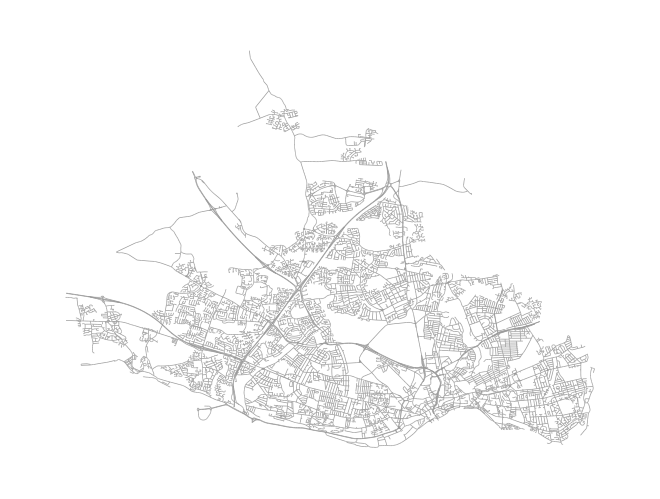

In [ ]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Plotting network covers")

    # Adjust suffix for weighting if applicable
    weighting_suffix = "_weighted" if weighting else ""

    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall' )
    G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    # G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable' + weighting_suffix)
    map_center = nxdraw(G_carall, "carall")
    
    ################################################### test to see which nodes we need to input for better plotting of hoods + tess ##############
    if poi_source == "neighbourhoods":
        with open(PATH["data"] + placeid + "/" + placeid + '_poi_tess_hoods_nnidscarall.csv') as f:
            nnids = [int(line.rstrip()) for line in f]
    else:
        # Load POIs
        with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
            nnids = [int(line.rstrip()) for line in f]
    ################################################### test to see which nodes we need to input for better plotting of hoods + tess ##############
    
    # Load results
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + weighting_suffix + ".pickle"
    with open(PATH["results"] + placeid + "/" + filename, 'rb') as f:
        res = pickle.load(f)
    
    # Load covers
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + ("_weighted_covers" if weighting else "_covers")
    with open(PATH["results"] + placeid + "/" + filename + ".pickle", 'rb') as f:
        covs = pickle.load(f)

    # Load existing covers
    filename = placeid + "_existing" + ("_covers_weighted" if weighting else "_covers")  
    with open(PATH["results"] + placeid + "/" + filename + ".pickle", 'rb') as f:
        cov_car = pickle.load(f)['carall']


    # Construct and plot patches from covers
    patchlist_car, patchlist_car_holes = cov_to_patchlist(cov_car, map_center)
    for GT, prune_quantile, cov in tqdm(zip(res["GTs"], res["prune_quantiles"], covs.values()), "Covers", total=len(res["prune_quantiles"])):
        fig = initplot()
        
        # Covers
        axes = fig.add_axes([0, 0, 1, 1])  # left, bottom, width, height (range 0 to 1)
        patchlist_bike, patchlist_bike_holes = cov_to_patchlist(cov, map_center)
        
        # Patch order due to alpha and hole handling (as mentioned in the original comment)
        patchlist_combined = (patchlist_car + patchlist_bike + patchlist_bike + 
                              patchlist_bike_holes + patchlist_bike_holes + patchlist_car_holes)
        pc = PatchCollection(patchlist_combined)
        
        # Define colors for different network layers
        colors = np.array([[255/255, 115/255, 56/255, 0.2] for _ in range(len(patchlist_car))])  # car orange
        if len(patchlist_bike):
            colors = np.append(colors, [[1, 1, 1, 1] for _ in range(len(patchlist_bike))], axis=0)  # bike white
            colors = np.append(colors, [[86/255, 220/255, 244/255, 0.4] for _ in range(len(patchlist_bike))], axis=0)  # bike blue
        if len(patchlist_bike_holes):
            colors = np.append(colors, [[1, 1, 1, 1] for _ in range(len(patchlist_bike_holes))], axis=0)  # bike holes white
        if len(patchlist_bike_holes):
            colors = np.append(colors, [[255/255, 115/255, 56/255, 0.2] for _ in range(len(patchlist_bike_holes))], axis=0)  # bike holes orange
        if len(patchlist_car_holes):
            colors = np.append(colors, [[1, 1, 1, 1] for _ in range(len(patchlist_car_holes))], axis=0)  # car holes white
        
        # Set colors and edge properties
        pc.set_facecolors(colors)
        pc.set_edgecolors(np.array([[0, 0, 0, 0.4] for _ in range(len(patchlist_combined))]))  # optional outline for patches
        axes.add_collection(pc)
        axes.set_aspect('equal')
        axes.set_xmargin(0.01)
        axes.set_ymargin(0.01)
        axes.plot()
        
        # Networks
        nxdraw(G_carall, "carall", map_center)
        nxdraw(GT, "bikegrown", map_center, nodesize=nodesize_grown)
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        
        # Save the plot
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTallcover_poi_' + poi_source + "_" + prune_measures[prune_measure] + 
                    "{:.3f}".format(prune_quantile) + weighting_suffix + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()


In [ ]:
print(PATH["results"] + placeid + "/" + filename + ".pickle", 'rb')

../../bikenwgrowth_external/results/newcastle/newcastle_existing_covers_weighted.pickle rb


In [ ]:
Audio(sound_file, autoplay=True)